In [3]:
from MSG_GAN.GAN import Generator
# script for generating samples from a trained model

import argparse
import os
from math import sqrt, ceil
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.backends import cudnn
from torchvision.utils import make_grid

# turn fast mode on
cudnn.benchmark = True

# define the device for the training script
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

depth = 6
latent_size = 512
generator_file = '../models/6/GAN_GEN_SHADOW_261.pth'

# create generator object:
print("Creating a generator object ...")
generator = nn.DataParallel(Generator(depth=depth, latent_size=latent_size).to(device))

# load the trained generator weights
print("loading the trained generator weights ...")
generator.load_state_dict(torch.load(generator_file, map_location='cpu'))

Creating a generator object ...
loading the trained generator weights ...


In [4]:
def latent_generator(num_samples, normalize_latents=True):
    latent = torch.randn(num_samples, latent_size)
    if normalize_latents:
        latent = (latent / latent.norm(dim=-1, keepdim=True) * (latent_size ** 0.5))
    #if self.label_train:
    latent[:, latent_size-1] = torch.randint(size=(1, num_samples), low=0, high=11)
    return latent

In [6]:
all_latents = latent_generator(11, latent_size).to(device)
all_latents[:, latent_size-1] = torch.Tensor([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]).reshape(1,11)
all_latents

tensor([[-0.8586,  1.1785,  2.3017,  ..., -0.8672,  1.8018,  0.0000],
        [-0.4292,  0.8443, -2.0387,  ..., -0.7780,  1.4753,  1.0000],
        [-0.2113,  1.0565, -0.5572,  ..., -1.2963,  0.0987,  2.0000],
        ...,
        [ 2.4319,  1.4125,  0.1235,  ..., -1.1321,  0.4231,  8.0000],
        [ 0.1552, -1.4250, -0.8864,  ...,  0.8751, -1.0983,  9.0000],
        [ 0.7563,  0.1879, -1.5707,  ...,  0.5059, -0.0560, 10.0000]])

In [25]:
all_latents = latent_generator(11, latent_size).to(device)
all_latents[:, latent_size-1] = torch.Tensor(np.arange(0.0, 2.2, 0.2)).reshape(1,11)
all_latents[:, latent_size-2] = torch.Tensor(np.arange(0.0, 11.0, 1)).reshape(1,11)
all_latents

tensor([[ 1.7352,  2.2465, -0.6014,  ..., -0.3059,  0.0000,  0.0000],
        [ 0.3765,  0.0683,  2.1204,  ..., -0.3244,  1.0000,  0.2000],
        [ 0.2840,  0.2815,  1.2852,  ..., -0.1908,  2.0000,  0.4000],
        ...,
        [-0.3380, -0.7177, -0.5853,  ..., -0.4279,  8.0000,  1.6000],
        [ 0.8805, -1.3884, -0.2892,  ..., -2.2298,  9.0000,  1.8000],
        [-0.0323, -1.0012,  0.5248,  ...,  0.5056, 10.0000,  2.0000]])

In [7]:
def adjust_dynamic_range(data, drange_in=(-1,1), drange_out=(0,1)):
    if drange_in != drange_out:
        scale = (np.float32(drange_out[1]) - np.float32(drange_out[0])) / (np.float32(drange_in[1]) - np.float32(drange_in[0]))
        bias = (np.float32(drange_out[0]) - np.float32(drange_in[0]) * scale)
        data = data * scale + bias
    return torch.clamp(data, min=0, max=1)

def get_image(gen, point):
    images = list(map(lambda x: x.detach(), gen(point)))
    images = [adjust_dynamic_range(image) for image in images]
    images = images[:-2] + images[-1:]
    images = list(map(lambda x: x.squeeze(dim=0), images))
    image = make_grid(images, nrow=int(ceil(sqrt(len(images)))), padding=0)
    return image.cpu().numpy().transpose(1, 2, 0)

100%|██████████| 11/11 [00:36<00:00,  3.32s/it]


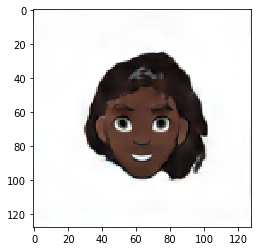

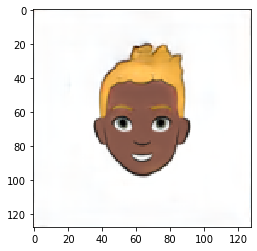

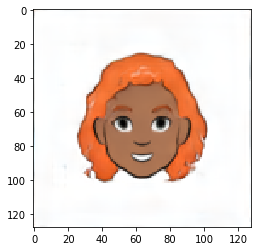

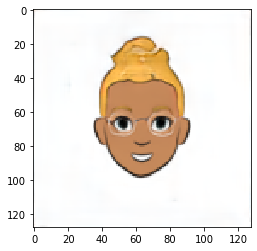

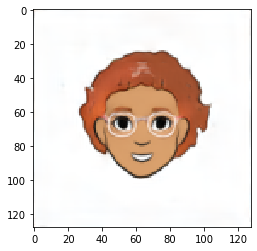

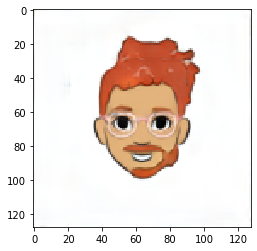

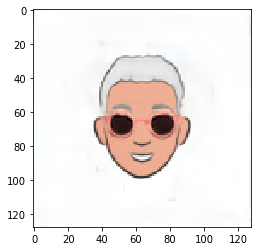

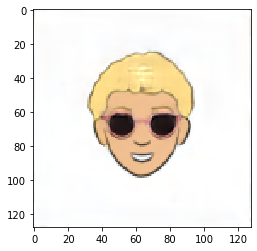

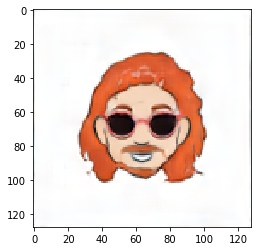

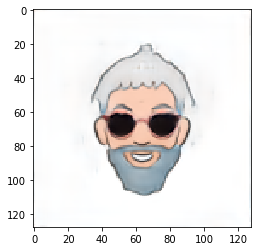

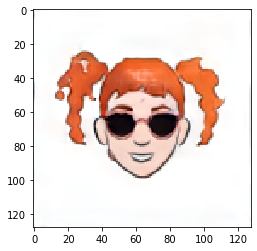

In [26]:
with torch.no_grad():
    for point in tqdm(all_latents):
        point = torch.unsqueeze(point, dim=0)
        images = list(map(lambda x: x.detach(), generator(point)))
        images = [adjust_dynamic_range(image) for image in images]
        plt.figure()
        plt.imshow((images[5][0].cpu().numpy().transpose(1, 2, 0)))

In [209]:
model = nn.Sequential(nn.Linear(1,128),
                      nn.Linear(128,256),
                      nn.LeakyReLU(),
                      nn.Linear(256,256),
                      nn.LeakyReLU(),
                      nn.Linear(256,128),
                      nn.Linear(128,1))

In [210]:
opt = torch.optim.Adam(model.parameters(), lr=0.01)
loss_func = nn.L1Loss()

In [211]:
model(torch.randn(2,1))

tensor([[-0.0356],
        [-0.0844]], grad_fn=<AddmmBackward>)

In [212]:
model.train()
for epoch in range(100):
    inp = torch.randn(500,1)
    tar = torch.randn(500,1) - 10
    out = model(inp)
    loss = loss_func(out, tar)
    print(loss)
    opt.zero_grad()
    loss.backward()
    opt.step()

tensor(10.0022, grad_fn=<L1LossBackward>)
tensor(4.7436, grad_fn=<L1LossBackward>)
tensor(21.4498, grad_fn=<L1LossBackward>)
tensor(3.2195, grad_fn=<L1LossBackward>)
tensor(6.7834, grad_fn=<L1LossBackward>)
tensor(8.8898, grad_fn=<L1LossBackward>)
tensor(9.3659, grad_fn=<L1LossBackward>)
tensor(9.5323, grad_fn=<L1LossBackward>)
tensor(9.1848, grad_fn=<L1LossBackward>)
tensor(7.2467, grad_fn=<L1LossBackward>)
tensor(6.7406, grad_fn=<L1LossBackward>)
tensor(4.7271, grad_fn=<L1LossBackward>)
tensor(2.8208, grad_fn=<L1LossBackward>)
tensor(3.6906, grad_fn=<L1LossBackward>)
tensor(1.3618, grad_fn=<L1LossBackward>)
tensor(3.4624, grad_fn=<L1LossBackward>)
tensor(1.1109, grad_fn=<L1LossBackward>)
tensor(4.5382, grad_fn=<L1LossBackward>)
tensor(2.6019, grad_fn=<L1LossBackward>)
tensor(2.3325, grad_fn=<L1LossBackward>)
tensor(3.4178, grad_fn=<L1LossBackward>)
tensor(2.5720, grad_fn=<L1LossBackward>)
tensor(1.0657, grad_fn=<L1LossBackward>)
tensor(2.3351, grad_fn=<L1LossBackward>)
tensor(1.5739,

(array([1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 4.000e+00, 1.000e+00,
        2.000e+00, 5.000e+00, 2.000e+00, 6.000e+00, 6.000e+00, 7.000e+00,
        1.400e+01, 1.600e+01, 2.100e+01, 2.400e+01, 3.900e+01, 3.400e+01,
        5.400e+01, 5.800e+01, 7.400e+01, 8.000e+01, 1.080e+02, 1.250e+02,
        1.470e+02, 1.910e+02, 2.280e+02, 2.390e+02, 2.820e+02, 3.150e+02,
        3.880e+02, 4.020e+02, 4.990e+02, 5.730e+02, 6.220e+02, 6.430e+02,
        7.660e+02, 8.440e+02, 8.990e+02, 1.008e+03, 1.054e+03, 1.054e+03,
        1.121e+03, 1.158e+03, 1.226e+03, 1.228e+03, 1.318e+03, 1.348e+03,
        1.365e+03, 1.392e+03, 1.286e+03, 1.293e+03, 1.269e+03, 1.230e+03,
        1.264e+03, 1.153e+03, 1.123e+03, 1.017e+03, 9.750e+02, 9.260e+02,
        8.820e+02, 8.160e+02, 7.030e+02, 6.720e+02, 6.130e+02, 5.600e+02,
        4.800e+02, 4.030e+02, 3.640e+02, 3.230e+02, 2.870e+02, 2.270e+02,
        1.780e+02, 1.720e+02, 1.370e+02, 1.280e+02, 8.900e+01, 9.300e+01,
        8.600e+01, 5.300e+01, 4.000e+0

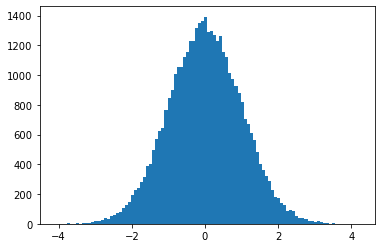

In [105]:
plt.hist(torch.randn(40000), bins=100)

In [213]:
a = model(torch.randn(40000,1))

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 3.000e+00,
        1.000e+00, 1.000e+00, 4.000e+00, 5.000e+00, 7.000e+00, 7.000e+00,
        9.000e+00, 4.000e+00, 6.000e+00, 6.000e+00, 8.000e+00, 5.000e+00,
        4.000e+00, 2.000e+00, 1.000e+01, 5.000e+00, 7.000e+00, 6.000e+00,
        6.000e+00, 7.000e+00, 5.000e+00, 2.000e+00, 6.000e+00, 7.000e+00,
        1.100e+01, 5.470e+03, 1.960e+03, 1.300e+03, 1.240e+03, 1.326e+03,
        1.191e+03, 2.087e+03, 2.704e+03, 8.552e+03, 1.358e+03, 7.620e+02,
        7.340e+02, 1.077e+03, 9.850e+0

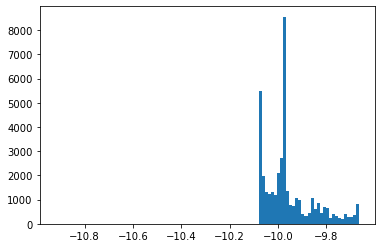

In [214]:
plt.hist(a.squeeze().detach().numpy(), bins=100)

In [2]:
from data_processing.DataLoader import FlatDirectoryImageDataset, get_transform, get_data_loader, LabeledImageDataset
dataset = LabeledImageDataset(data_dir='/Users/jhjiang/Downloads/BMSG-GAN/data/train_images/0/',
                              transform=get_transform((int(np.power(2, 6 + 1)), int(np.power(2, 6 + 1))),
                              flip_horizontal=False))

  0%|          | 0/20000 [00:00<?, ?it/s]

reading dir...


100%|██████████| 20000/20000 [00:46<00:00, 432.60it/s] 


In [9]:
data = get_data_loader(dataset, 5, 3)
for (i, batch) in enumerate(data, 1):
    print(i)
    img = batch[1]
    print(img.shape)
    break

1
torch.Size([5])


In [21]:
img.shape

torch.Size([5, 4, 128, 128])

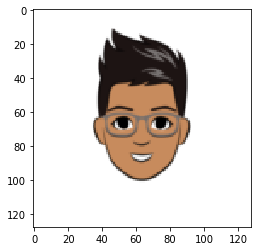

In [37]:
from PIL import Image

images = [adjust_dynamic_range(image) for image in img]
plt.imshow((images[0].cpu().numpy().transpose(1, 2, 0)))

In [33]:
dataset = FlatDirectoryImageDataset(data_dir='/Users/jhjiang/Downloads/BMSG-GAN/data/train_images/0/',
                                    transform=get_transform((int(np.power(2, 6 + 1)), int(np.power(2, 6 + 1))),
                                    flip_horizontal=False))

In [34]:
data = get_data_loader(dataset, 5, 3)
for (i, batch) in enumerate(data,1):
    print(i)
    img = batch
    break

1


In [29]:
(images[0][:3].cpu().numpy().transpose(1, 2, 0)).shape

(128, 128, 3)

In [36]:
img.shape

torch.Size([5, 3, 128, 128])

In [8]:
def latent_generator(num_samples, latent_size, normalize_latents=True, label_train=True):
    latent = torch.randn(num_samples, latent_size)
    if normalize_latents:
        latent = (latent / latent.norm(dim=-1, keepdim=True) * (latent_size ** 0.5))
    if label_train:
        latent[:, latent_size-1] = torch.randint(size=(1, num_samples), low=0, high=2)
    return latent

In [25]:
latent_generator(10, 5, True)[:, 4].reshape(10, 1).int()

tensor([[1],
        [1],
        [0],
        [1],
        [1],
        [0],
        [0],
        [1],
        [0],
        [1]], dtype=torch.int32)

In [16]:
loss = nn.CrossEntropyLoss()
inputs = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
output = loss(inputs, target)
output.backward()

In [22]:
inputs = torch.randn(20, 5, requires_grad=True)
target = torch.empty(20, dtype=torch.long).random_(5)

In [24]:
output = loss(inputs, target)
output

tensor(1.7407, grad_fn=<NllLossBackward>)

In [40]:
a = torch.Tensor(size = (20,5,1,1))

In [25]:
all_latents[:, 510:512][:, 0]

tensor([ 0.3464,  2.3110,  0.3457,  0.7307, -0.4001, -0.1296,  0.1126,  0.4539,
        -0.7081, -0.3654, -0.7565])